In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import collections

In [2]:
def other(x):
    if ((x=='exchanges')|(x=='finance')|(x=='games')|(x=='gambling')|(x=='high-risk')): 
        return x 
    else: 
        return 'other'

In [3]:
df = pd.read_csv('../SC-Dapp-scraping/data/dapps_source_code_parsed_open_source_2021-01-08.csv')
df = df[df.SC_full!='\n']
df.drop('Unnamed: 0', axis=1, inplace=True)
df.category = df.category.apply(other)
df.comments.fillna('empty', inplace=True)

In [4]:
RS     = 42
SPLITS = 3

In [5]:
X = df.drop('category', axis=1)
y = df.category

In [6]:
y.value_counts()

exchanges    470
finance      317
games        272
other        238
gambling      71
high-risk     60
Name: category, dtype: int64

In [7]:
print(f'There are {df.shape[0]} source codes from {df.slug.nunique()} dapps')

There are 1428 source codes from 473 dapps


In [8]:
X, X_test, y, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [9]:
print(f'X_train shape {X.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (1142, 12)
X_test shape (286, 12)


In [10]:
y_test.value_counts()

exchanges    94
finance      64
games        54
other        48
gambling     14
high-risk    12
Name: category, dtype: int64

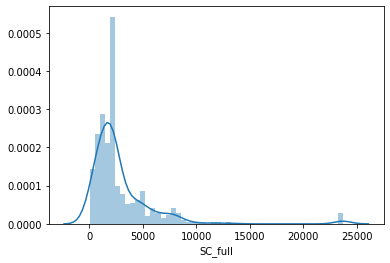

In [11]:
length_SC = X.SC_full.apply(lambda x: len(x.split()))
sns.distplot(length_SC)

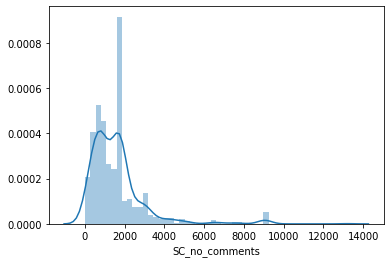

In [12]:
length_SC = X.SC_no_comments.apply(lambda x: len(x.split()))
sns.distplot(length_SC)

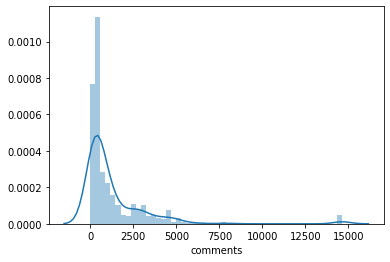

In [13]:
length_SC = X.comments.apply(lambda x: len(x.split()))
sns.distplot(length_SC)

## Full code

### Ridge Regression

In [14]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS, shuffle=True)

In [15]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 10200, 200)

# use best C

C_parameter = [1]
FEATURES    = [10000]

In [16]:
names = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [17]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 10000 C:1 AUC ROC: 0.945 ###  AUC PRC: 0.761


In [18]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.990
aucroc_finance      0.953
aucroc_gambling     0.898
aucroc_games        0.956
aucroc_high-risk    0.930
dtype: float64

In [19]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.986
aucprc_finance      0.888
aucprc_gambling     0.501
aucprc_games        0.878
aucprc_high-risk    0.552
dtype: float64

In [20]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.987,0.944,0.904,0.955,0.917,0.982,0.862,0.482,0.902,0.566
1,0.992,0.949,0.899,0.960,0.942,0.987,0.889,0.517,0.865,0.477
2,0.991,0.966,0.890,0.952,0.930,0.989,0.913,0.505,0.866,0.612


In [21]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier    = LogisticRegression(C=c_p, 
                                    solver='sag', 
                                    random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [22]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.988,0.967,0.914,0.972,0.983,0.985,0.925,0.482,0.914,0.72,0.951,0.804


In [23]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.962
dtype: float64

In [24]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.805
dtype: float64

### Lasso Regression

In [25]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 10200, 200)

# use best C

C_parameter = [1]
FEATURES    = [10000]

In [26]:
names  = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [27]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val   = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, 
                                                       solver='liblinear', 
                                                       random_state=RS, 
                                                       penalty='l1')
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 10000 C:1 AUC ROC: 0.84 ###  AUC PRC: 0.605


In [28]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.949
aucroc_finance      0.881
aucroc_gambling     0.688
aucroc_games        0.904
aucroc_high-risk    0.780
dtype: float64

In [29]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.944
aucprc_finance      0.756
aucprc_gambling     0.300
aucprc_games        0.714
aucprc_high-risk    0.310
dtype: float64

In [30]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.918,0.861,0.626,0.898,0.718,0.918,0.692,0.185,0.711,0.214
1,0.962,0.887,0.707,0.919,0.819,0.953,0.776,0.317,0.783,0.276
2,0.966,0.896,0.732,0.895,0.802,0.960,0.799,0.398,0.648,0.440


In [31]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, 
                                    solver='liblinear', 
                                    random_state=RS, 
                                    penalty='l1')
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [32]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.961,0.927,0.714,0.917,0.847,0.962,0.844,0.238,0.804,0.554,0.87,0.601


In [33]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.873
dtype: float64

In [34]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.667
dtype: float64

### Random Forest

In [35]:
for FEATURE in FEATURES:
    metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
    for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer     = TfidfVectorizer(
                        sublinear_tf  = True,
                        strip_accents = 'unicode',
                        analyzer      = 'word',
                        token_pattern = r'\w{1,}',
                        ngram_range   = (1, 1),
                        max_features  = FEATURE)
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)

            le = LabelBinarizer()
            le.fit(y_train)

            y_train = le.transform(y_train)
            y_val   = le.transform(y_val)


            classifier = RandomForestClassifier(n_estimators=600, 
                                                         max_depth=None, 
                                                         max_features='auto',
                                                         min_samples_split=2, 
                                                         verbose = True, 
                                                         n_jobs=20, 
                                                         random_state=RS)
            classifier.fit(train_word_features, y_train)
            probs = classifier.predict_proba(val_word_features)

            assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()        
            for i, cl in enumerate(le.classes_[le.classes_!='other']):
                auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
                auc_pr_class  = average_precision_score(y_val[:,i], probs[i][:,1])

                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

    print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

AUC ROC: 0.947 ###  AUC PRC: 0.77


In [36]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.979,0.948,0.907,0.950,0.948,0.974,0.858,0.431,0.898,0.618
1,0.985,0.954,0.905,0.948,0.928,0.981,0.900,0.528,0.841,0.546
2,0.986,0.974,0.911,0.949,0.937,0.984,0.913,0.572,0.874,0.632


In [37]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.5s finished


In [38]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.988,0.973,0.944,0.971,0.974,0.984,0.942,0.572,0.912,0.7


In [39]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.97
dtype: float64

In [40]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.822
dtype: float64

### SVM

In [41]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l2']
alpha = [0.0001]
max_iter = [1000] 

for p in penalty:
      for a in alpha:
            for it in max_iter:

                print(f'-------------')
                print(f'penalty {p}')
                print(f'alpha {a}')
                print(f'max_iter {it}')
                print(f'-------------')


                metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
                for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                    X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
                    y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                    word_vectorizer     = TfidfVectorizer(sublinear_tf  = True,
                                                        strip_accents = 'unicode',
                                                        analyzer      = 'word',
                                                        token_pattern = r'\w{1,}',
                                                        ngram_range   = (1, 1),
                                                        max_features  = FEATURES[0])
                    word_vectorizer.fit(X_train)
                    train_word_features = word_vectorizer.transform(X_train)
                    val_word_features   = word_vectorizer.transform(X_val)

                    le = LabelBinarizer()
                    le.fit(y_train)

                    y_train = le.transform(y_train)
                    y_val   = le.transform(y_val)

                    assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

                    for i, cl in enumerate(le.classes_[le.classes_!='other']):
                        classifier = SGDClassifier(n_jobs=20, 
                                                   random_state=RS, 
                                                   loss='log', 
                                                   shuffle=False, 
                                                   penalty=p, 
                                                   alpha=a, 
                                                   max_iter=it)
                        classifier.fit(train_word_features, y_train[:,i])
                        probs      = classifier.predict_proba(val_word_features)[:,1]
                        auc_roc_class = roc_auc_score(y_val[:,i], probs)
                        auc_pr_class = average_precision_score(y_val[:,i], probs)

                        metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                        metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   


                print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l2
alpha 0.0001
max_iter 1000
-------------
AUC ROC: 0.945 ###  AUC PRC: 0.784


In [42]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.990,0.953,0.902,0.967,0.905,0.984,0.883,0.505,0.922,0.528
1,0.995,0.954,0.902,0.956,0.943,0.992,0.898,0.638,0.879,0.616
2,0.991,0.973,0.876,0.955,0.919,0.988,0.927,0.529,0.889,0.583


In [43]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.992
aucroc_finance      0.960
aucroc_gambling     0.893
aucroc_games        0.959
aucroc_high-risk    0.922
dtype: float64

In [44]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.988
aucprc_finance      0.903
aucprc_gambling     0.557
aucprc_games        0.897
aucprc_high-risk    0.576
dtype: float64

In [45]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier = SGDClassifier(n_jobs=20, 
                               random_state=RS, 
                               loss='log', 
                               shuffle=False, 
                               penalty=penalty[0], 
                               alpha=alpha[0], 
                               max_iter=max_iter[0])
    
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [46]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.987,0.972,0.892,0.977,0.976,0.983,0.944,0.482,0.934,0.668


### Only comments

### Ridge Regression

In [47]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 7700, 200)

# use best C

C_parameter = [1]
FEATURES    = [6100]

In [48]:
names = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [49]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val   = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, 
                                                       solver='sag', 
                                                       random_state=RS)
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 6100 C:1 AUC ROC: 0.919 ###  AUC PRC: 0.698


In [50]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.979
aucroc_finance      0.939
aucroc_gambling     0.847
aucroc_games        0.941
aucroc_high-risk    0.890
dtype: float64

In [51]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.974
aucprc_finance      0.857
aucprc_gambling     0.358
aucprc_games        0.838
aucprc_high-risk    0.463
dtype: float64

In [52]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.968,0.932,0.821,0.950,0.918,0.964,0.835,0.380,0.883,0.481
1,0.986,0.930,0.849,0.949,0.930,0.980,0.862,0.404,0.824,0.509
2,0.983,0.954,0.871,0.923,0.823,0.977,0.874,0.291,0.808,0.398


In [53]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()

for i, cl in enumerate(le.classes_):
    classifier    = LogisticRegression(C=c_p, 
                                    solver='sag', 
                                    random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [54]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.991,0.959,0.88,0.972,0.976,0.986,0.91,0.508,0.912,0.701,0.931,0.759


In [55]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.952
dtype: float64

In [56]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.796
dtype: float64

### Lasso Regression

In [57]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 7700, 200)

# use best C

C_parameter = [1]
FEATURES    = [6100]

In [58]:
names  = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [59]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val   = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, 
                                                       solver='liblinear', 
                                                       random_state=RS, 
                                                       penalty='l1')
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 6100 C:1 AUC ROC: 0.799 ###  AUC PRC: 0.532


In [60]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.935
aucroc_finance      0.876
aucroc_gambling     0.646
aucroc_games        0.880
aucroc_high-risk    0.656
dtype: float64

In [61]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.931
aucprc_finance      0.750
aucprc_gambling     0.143
aucprc_games        0.703
aucprc_high-risk    0.136
dtype: float64

In [62]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.903,0.859,0.658,0.875,0.598,0.899,0.699,0.184,0.709,0.091
1,0.947,0.894,0.666,0.890,0.719,0.944,0.799,0.160,0.712,0.126
2,0.954,0.876,0.613,0.876,0.651,0.950,0.751,0.084,0.689,0.190


In [63]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, 
                                    solver='liblinear', 
                                    random_state=RS, 
                                    penalty='l1')
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [64]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.982,0.93,0.734,0.942,0.88,0.977,0.852,0.217,0.844,0.409,0.837,0.473


In [65]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.884
dtype: float64

In [66]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.629
dtype: float64

### Random Forest

In [67]:
metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
for c, (train_index, val_index) in enumerate(kf.split(X, y)):

        X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
        y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
        word_vectorizer     = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
        word_vectorizer.fit(X_train)
        train_word_features = word_vectorizer.transform(X_train)
        val_word_features   = word_vectorizer.transform(X_val)

        le = LabelBinarizer()
        le.fit(y_train)

        y_train = le.transform(y_train)
        y_val   = le.transform(y_val)

        
        classifier = RandomForestClassifier(n_estimators=600, 
                                             max_depth=None, 
                                             max_features='auto',
                                             min_samples_split=2, 
                                             verbose = True, 
                                             n_jobs=20, 
                                             random_state=RS)
        classifier.fit(train_word_features, y_train)
        probs = classifier.predict_proba(val_word_features)
        
        assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()        
        for i, cl in enumerate(le.classes_[le.classes_!='other']):
            auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
            auc_pr_class  = average_precision_score(y_val[:,i], probs[i][:,1])

            metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
            metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

AUC ROC: 0.921 ###  AUC PRC: 0.715


In [68]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.973,0.936,0.841,0.946,0.894,0.964,0.823,0.466,0.891,0.548
1,0.986,0.927,0.860,0.935,0.913,0.980,0.854,0.408,0.790,0.523
2,0.982,0.960,0.864,0.928,0.867,0.978,0.864,0.361,0.830,0.440


In [69]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.4s finished


In [70]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.984,0.972,0.89,0.974,0.977,0.981,0.937,0.452,0.924,0.675


In [71]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.959
dtype: float64

In [72]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.794
dtype: float64

### SVM

In [73]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l2']
alpha = [0.0001]
max_iter = [1000] 

for p in penalty:
      for a in alpha:
            for it in max_iter:

                print(f'-------------')
                print(f'penalty {p}')
                print(f'alpha {a}')
                print(f'max_iter {it}')
                print(f'-------------')


                metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
                for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                    X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
                    y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                    word_vectorizer     = TfidfVectorizer(sublinear_tf  = True,
                                                            strip_accents = 'unicode',
                                                            analyzer      = 'word',
                                                            token_pattern = r'\w{1,}',
                                                            ngram_range   = (1, 1),
                                                            max_features  = FEATURES[0])
                    word_vectorizer.fit(X_train)
                    train_word_features = word_vectorizer.transform(X_train)
                    val_word_features   = word_vectorizer.transform(X_val)

                    le = LabelBinarizer()
                    le.fit(y_train)

                    y_train = le.transform(y_train)
                    y_val   = le.transform(y_val)

                    assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

                    for i, cl in enumerate(le.classes_[le.classes_!='other']):
                        classifier = SGDClassifier(n_jobs=20, 
                                                   random_state=RS, 
                                                   loss='log', 
                                                   shuffle=False, 
                                                   penalty=p, 
                                                   alpha=a, 
                                                   max_iter=it)
                        classifier.fit(train_word_features, y_train[:,i])
                        probs      = classifier.predict_proba(val_word_features)[:,1]
                        auc_roc_class = roc_auc_score(y_val[:,i], probs)
                        auc_pr_class = average_precision_score(y_val[:,i], probs)

                        metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                        metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   


                print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l2
alpha 0.0001
max_iter 1000
-------------
AUC ROC: 0.931 ###  AUC PRC: 0.731


In [74]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.982,0.947,0.881,0.958,0.914,0.975,0.866,0.483,0.902,0.469
1,0.990,0.936,0.884,0.948,0.946,0.986,0.863,0.458,0.845,0.611
2,0.988,0.960,0.871,0.931,0.822,0.983,0.882,0.379,0.844,0.414


In [75]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.987
aucroc_finance      0.948
aucroc_gambling     0.879
aucroc_games        0.946
aucroc_high-risk    0.894
dtype: float64

In [76]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.981
aucprc_finance      0.870
aucprc_gambling     0.440
aucprc_games        0.864
aucprc_high-risk    0.498
dtype: float64

In [77]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier = SGDClassifier(n_jobs=20, 
                               random_state=RS, 
                               loss='log', 
                               shuffle=False, 
                               penalty=penalty[0], 
                               alpha=alpha[0], 
                               max_iter=max_iter[0])
    
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [78]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.988,0.963,0.879,0.978,0.976,0.983,0.921,0.511,0.933,0.626


## WITHOUT Comments, only code

### Ridge Regression

In [79]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 7700, 200)

# use best C

C_parameter = [1]
FEATURES    = [7300]

In [80]:
names  = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [81]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['SC_no_comments'], X.iloc[val_index]['SC_no_comments']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 7300 C:1 AUC ROC: 0.946 ###  AUC PRC: 0.759


In [82]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.986
aucroc_finance      0.951
aucroc_gambling     0.910
aucroc_games        0.950
aucroc_high-risk    0.931
dtype: float64

In [83]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.982
aucprc_finance      0.878
aucprc_gambling     0.525
aucprc_games        0.868
aucprc_high-risk    0.543
dtype: float64

In [84]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.981,0.948,0.918,0.951,0.914,0.976,0.871,0.507,0.896,0.510
1,0.987,0.935,0.909,0.952,0.922,0.982,0.852,0.517,0.852,0.457
2,0.991,0.969,0.902,0.948,0.957,0.988,0.910,0.550,0.857,0.661


In [85]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_no_comments'])
train_word_features  = word_vectorizer.transform(X['SC_no_comments'])
test_word_features   = word_vectorizer.transform(X_test['SC_no_comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier    = LogisticRegression(C=c_p, 
                                    solver='sag', 
                                    random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [86]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.983,0.965,0.916,0.957,0.988,0.981,0.914,0.483,0.868,0.795,0.948,0.776


In [87]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.959
dtype: float64

In [88]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.803
dtype: float64

### Lasso Regression

In [89]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 10200, 200)

# use best C

C_parameter = [1]
FEATURES    = [7300]

In [90]:
names  = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [91]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['SC_no_comments'], X.iloc[val_index]['SC_no_comments']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, 
                                                       solver='liblinear', 
                                                       random_state=RS, 
                                                       penalty='l1')
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 7300 C:1 AUC ROC: 0.809 ###  AUC PRC: 0.573


In [92]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.965
aucroc_finance      0.872
aucroc_gambling     0.627
aucroc_games        0.887
aucroc_high-risk    0.694
dtype: float64

In [93]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.960
aucprc_finance      0.724
aucprc_gambling     0.210
aucprc_games        0.675
aucprc_high-risk    0.295
dtype: float64

In [94]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.950,0.828,0.604,0.891,0.633,0.945,0.636,0.182,0.665,0.169
1,0.966,0.880,0.686,0.896,0.644,0.960,0.741,0.386,0.738,0.161
2,0.979,0.908,0.590,0.874,0.806,0.974,0.795,0.061,0.621,0.554


In [95]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_no_comments'])
train_word_features  = word_vectorizer.transform(X['SC_no_comments'])
test_word_features   = word_vectorizer.transform(X_test['SC_no_comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, 
                                    solver='liblinear', 
                                    random_state=RS, 
                                    penalty='l1')
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [96]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucroc_other,aucprc_other
0,0.96,0.915,0.832,0.922,0.934,0.959,0.813,0.363,0.769,0.656,0.857,0.561


In [97]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.903
dtype: float64

In [98]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.687
dtype: float64

### Random Forest

In [99]:
metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
for c, (train_index, val_index) in enumerate(kf.split(X, y)):

        X_train, X_val      = X.iloc[train_index]['SC_no_comments'], X.iloc[val_index]['SC_no_comments']
        y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
        word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
        word_vectorizer.fit(X_train)
        train_word_features = word_vectorizer.transform(X_train)
        val_word_features   = word_vectorizer.transform(X_val)

        le = LabelBinarizer()
        le.fit(y_train)

        y_train = le.transform(y_train)
        y_val   = le.transform(y_val)

        
        classifier = RandomForestClassifier(n_estimators=600, 
                                                     max_depth=None, 
                                                     max_features='auto',
                                                     min_samples_split=2, 
                                                     verbose = True, 
                                                     n_jobs=20, 
                                                     random_state=RS)
        classifier.fit(train_word_features, y_train)
        probs = classifier.predict_proba(val_word_features)
        
        assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()        
        for i, cl in enumerate(le.classes_[le.classes_!='other']):
            auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
            auc_pr_class  = average_precision_score(y_val[:,i], probs[i][:,1])

            metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
            metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

AUC ROC: 0.947 ###  AUC PRC: 0.76


[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.5s finished


In [100]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.980,0.958,0.923,0.948,0.931,0.974,0.879,0.462,0.895,0.547
1,0.981,0.942,0.895,0.942,0.944,0.979,0.874,0.510,0.831,0.573
2,0.986,0.972,0.901,0.943,0.954,0.983,0.915,0.493,0.863,0.629


In [101]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_no_comments'])
train_word_features  = word_vectorizer.transform(X['SC_no_comments'])
test_word_features   = word_vectorizer.transform(X_test['SC_no_comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.4s finished


In [102]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.986,0.974,0.938,0.966,0.986,0.983,0.94,0.491,0.907,0.771


In [103]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.97
dtype: float64

In [104]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.818
dtype: float64

### SVM

In [105]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l2']
alpha = [0.0001]
max_iter = [1000] 

for p in penalty:
      for a in alpha:
            for it in max_iter:

                print(f'-------------')
                print(f'penalty {p}')
                print(f'alpha {a}')
                print(f'max_iter {it}')
                print(f'-------------')


                metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
                for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                    X_train, X_val      = X.iloc[train_index]['SC_no_comments'], X.iloc[val_index]['SC_no_comments']
                    y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                    word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                                        strip_accents = 'unicode',
                                                        analyzer      = 'word',
                                                        token_pattern = r'\w{1,}',
                                                        ngram_range   = (1, 1),
                                                        max_features  = FEATURES[0])
                    word_vectorizer.fit(X_train)
                    train_word_features = word_vectorizer.transform(X_train)
                    val_word_features   = word_vectorizer.transform(X_val)

                    le = LabelBinarizer()
                    le.fit(y_train)

                    y_train = le.transform(y_train)
                    y_val   = le.transform(y_val)

                    assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

                    for i, cl in enumerate(le.classes_[le.classes_!='other']):
                        classifier = SGDClassifier(n_jobs=20, 
                                                   random_state=RS, 
                                                   loss='log', 
                                                   shuffle=False, 
                                                   penalty=p, 
                                                   alpha=a, 
                                                   max_iter=it)
                        classifier.fit(train_word_features, y_train[:,i])
                        probs         = classifier.predict_proba(val_word_features)[:,1]
                        auc_roc_class = roc_auc_score(y_val[:,i], probs)
                        auc_pr_class  = average_precision_score(y_val[:,i], probs)

                        metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                        metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   


                print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l2
alpha 0.0001
max_iter 1000
-------------
AUC ROC: 0.94 ###  AUC PRC: 0.77


In [106]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.980,0.954,0.898,0.963,0.893,0.975,0.890,0.522,0.918,0.529
1,0.990,0.937,0.906,0.946,0.916,0.985,0.870,0.602,0.849,0.614
2,0.991,0.969,0.849,0.944,0.965,0.987,0.913,0.353,0.867,0.677


In [107]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.987
aucroc_finance      0.953
aucroc_gambling     0.884
aucroc_games        0.951
aucroc_high-risk    0.925
dtype: float64

In [108]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.982
aucprc_finance      0.891
aucprc_gambling     0.492
aucprc_games        0.878
aucprc_high-risk    0.607
dtype: float64

In [109]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['SC_no_comments'])
train_word_features  = word_vectorizer.transform(X['SC_no_comments'])
test_word_features   = word_vectorizer.transform(X_test['SC_no_comments'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier = SGDClassifier(n_jobs=20, 
                               random_state=RS, 
                               loss='log', 
                               shuffle=False, 
                               penalty=penalty[0], 
                               alpha=alpha[0], 
                               max_iter=max_iter[0])
    
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [110]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.98,0.973,0.905,0.97,0.976,0.979,0.943,0.574,0.919,0.717
